<a href="https://www.kaggle.com/code/alexredna/mlsd-task?scriptVersionId=184062804" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Ваша задача провести анализ данных, построить и оценить модель классификации. Выбор метрик и моделей за вами. Решение должно быть загружено в формате .ipynb или .html

Оценка работ будет производиться по следующим критериям: 

- Качественный EDA
- Корректные и обоснованные трансформации данных
- Корректное и обоснованное обучение и оценка модели
- Качество кода и чистота jupyter notebook

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import sklearn.metrics as m
import shap

from imblearn.over_sampling import RandomOverSampler

from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

# EDA

In [2]:
data = pd.read_csv('/kaggle/input/mlsd-task-data/dataset.csv')
data.sample(10, random_state=42)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
40907,5599,HR,region_16,Bachelor's,m,other,1,35,5.0,10,0,0,47,0
51939,73176,Sales & Marketing,region_7,Bachelor's,m,other,3,33,1.0,4,0,0,51,0
6978,13157,Finance,region_2,Bachelor's,m,other,2,38,3.0,11,0,0,64,0
12814,7458,Operations,region_22,Bachelor's,f,other,1,33,1.0,8,0,0,56,0
22921,28446,Technology,region_7,Bachelor's,f,other,1,37,1.0,4,0,0,80,0
33215,66151,Procurement,region_7,Bachelor's,f,other,1,30,5.0,2,1,0,71,0
4028,13944,Technology,region_21,Master's & above,m,sourcing,2,34,3.0,9,0,0,82,0
1390,65698,Sales & Marketing,region_13,Bachelor's,f,sourcing,1,29,4.0,5,0,0,51,0
20735,23329,Finance,region_23,Master's & above,m,other,2,40,3.0,4,0,0,76,1
17224,51932,Procurement,region_17,Bachelor's,m,other,1,51,4.0,18,1,0,69,0


In [3]:
data.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


кажется должен быть дисбаланс классов в повышении, проверим

In [4]:
data[['is_promoted']].value_counts(normalize=True)

is_promoted
0              0.91483
1              0.08517
Name: proportion, dtype: float64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


null в образовании логично, если неизвестно/нет степени, а вот с рейтингом не так тривиально, проверим что там

In [6]:
data[data.previous_year_rating.isnull()].sample(10, random_state=42)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
14761,72551,HR,region_2,Bachelor's,f,sourcing,1,29,NaN,1,0,0,50,0
22999,69507,Procurement,region_20,Bachelor's,m,other,1,27,NaN,1,1,0,69,0
53180,39345,Sales & Marketing,region_22,Bachelor's,m,other,5,28,NaN,1,0,0,47,0
52682,8150,Analytics,region_22,Bachelor's,m,other,1,27,NaN,1,0,0,88,0
36410,1894,Legal,region_2,Below Secondary,m,sourcing,1,26,NaN,1,0,0,58,0
13930,70047,Operations,region_8,Bachelor's,m,other,1,25,NaN,1,1,0,60,0
37816,21724,Sales & Marketing,region_22,Bachelor's,m,sourcing,1,26,NaN,1,0,0,53,0
11171,33083,Sales & Marketing,region_1,Bachelor's,m,other,2,28,NaN,1,0,0,50,0
22048,6561,Sales & Marketing,region_31,Bachelor's,m,sourcing,1,29,NaN,1,1,0,51,0
46156,60202,Technology,region_14,Bachelor's,m,other,1,29,NaN,1,0,0,78,0


In [7]:
data['awards_won?'].value_counts()

awards_won?
0    53538
1     1270
Name: count, dtype: int64

кажется что первый год в компании, нет наград, не промотятся. 

проверим это

In [8]:
data[data.previous_year_rating.isnull()][['length_of_service', 'awards_won?', 'is_promoted']].describe()

,length_of_service,awards_won?,is_promoted
count,4124.0,4124.000000,4124.000000
mean,1.0,0.023278,0.082202
std,0.0,0.150805,0.274705
min,1.0,0.000000,0.000000
25%,1.0,0.000000,0.000000
50%,1.0,0.000000,0.000000
75%,1.0,0.000000,0.000000
max,1.0,1.000000,1.000000


выходит что действительно первый год в компании, но повышения бывают, и награды иногда

In [9]:
data[['education']].value_counts(normalize=True)

education       
Bachelor's          0.699803
Master's & above    0.284834
Below Secondary     0.015363
Name: proportion, dtype: float64

все же null в образовании это просто что-то неизвестное

In [10]:
data.fillna({'previous_year_rating' : 0, 'education' : 'unknown'}, inplace=True)
data.isnull().any()

employee_id             False
department              False
region                  False
education               False
gender                  False
recruitment_channel     False
no_of_trainings         False
age                     False
previous_year_rating    False
length_of_service       False
KPIs_met >80%           False
awards_won?             False
avg_training_score      False
is_promoted             False
dtype: bool

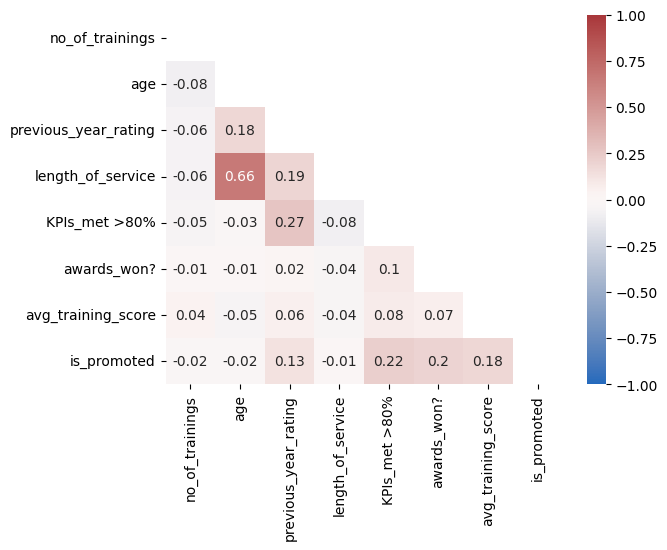

In [11]:
matrix = data.select_dtypes(include='number').drop('employee_id', axis=1).corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

корреляция между годами работы и возрастом очевидна, kpi и повышение тоже логично. Рейтинг предыдущего года тоже неплохо коррелирует с тем что может положительно влиять на повышение. Не вполне понятно, что такое 'no_of_trainings'

проверяем категориальные данные

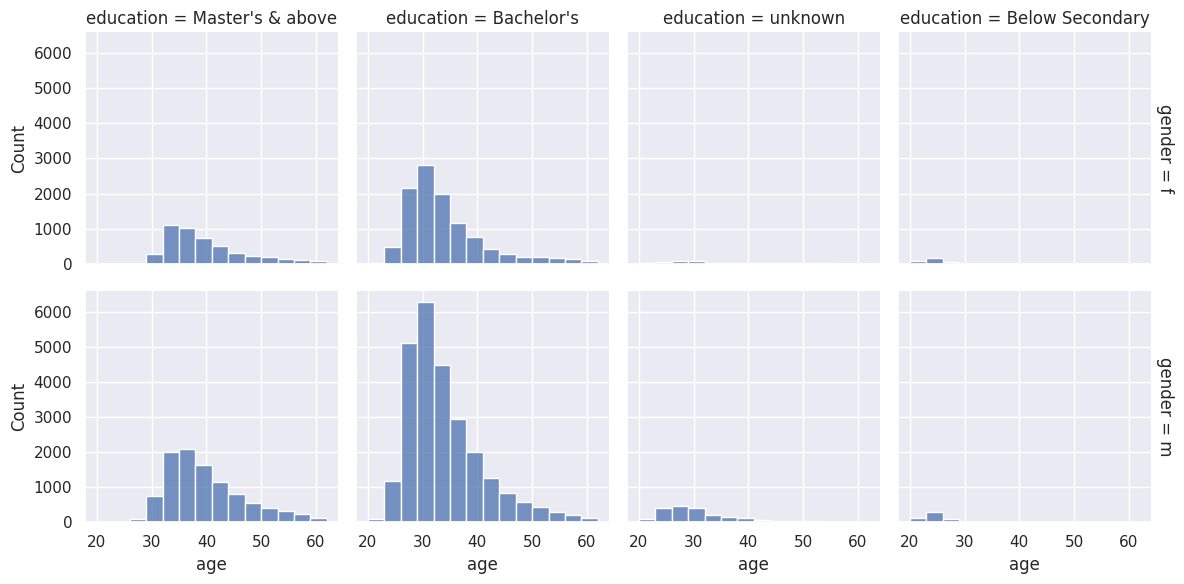

In [12]:
sns.set_theme(style='darkgrid')
sns.displot(
    data=data, x='age', row='gender', col='education',
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)

In [13]:
data[['gender']].value_counts(normalize=True)

gender
m         0.702379
f         0.297621
Name: proportion, dtype: float64

Небольшой гендерный дисбаланс, но не критично

# Model training

Натренируем катбуст, он автоэнкодит категориальные фичи и не требователен к скейлингу и нормализации

In [14]:
data.sample()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
1645,11864,HR,region_2,Bachelor's,m,other,1,49,5.0,7,0,0,54,0


поскольку у нас явный дисбаланс классов, попробуем оверсемплинг (upd: это помогло)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data[data.columns.drop(['employee_id', 'is_promoted'])], data['is_promoted'], test_size=0.2, random_state=42)
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=42)
display(X_train.sample(random_state=42))
display(y_train.sample(random_state=42))

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
61636,Sales & Marketing,region_22,Bachelor's,m,other,2,35,4.0,9,1,0,51


61636    1
Name: is_promoted, dtype: int64

In [16]:
cat_features = ['department', 'region', 'education', 'gender', 'recruitment_channel', 'KPIs_met >80%', 'awards_won?']

In [17]:
train_pool = Pool(X_train, label=y_train, cat_features=cat_features)
eval_pool = Pool(X_val, label=y_val, cat_features=cat_features)

In [18]:
model = CatBoostClassifier(
    loss_function='Logloss', 
    iterations=500, 
    learning_rate=0.1, 
    depth=8, 
    l2_leaf_reg=3,
    od_wait=10,
    od_type='Iter',
    random_state = 42
)
model.fit(train_pool, eval_set=eval_pool, verbose_eval=30)

0:	learn: 0.6270658	test: 0.6274377	best: 0.6274377 (0)	total: 166ms	remaining: 1m 22s
30:	learn: 0.3469225	test: 0.3746079	best: 0.3746079 (30)	total: 3.28s	remaining: 49.6s
60:	learn: 0.3152127	test: 0.3510504	best: 0.3510504 (60)	total: 5.91s	remaining: 42.5s
90:	learn: 0.2964743	test: 0.3385713	best: 0.3385713 (90)	total: 8.35s	remaining: 37.5s
120:	learn: 0.2810585	test: 0.3286725	best: 0.3286725 (120)	total: 11s	remaining: 34.5s
150:	learn: 0.2686996	test: 0.3214421	best: 0.3214162 (149)	total: 13.7s	remaining: 31.6s
180:	learn: 0.2577669	test: 0.3143943	best: 0.3143943 (180)	total: 16.3s	remaining: 28.7s
210:	learn: 0.2457033	test: 0.3067690	best: 0.3067690 (210)	total: 18.9s	remaining: 25.9s
240:	learn: 0.2378161	test: 0.3022299	best: 0.3022299 (240)	total: 21.6s	remaining: 23.2s
270:	learn: 0.2301664	test: 0.2976407	best: 0.2976407 (270)	total: 24.3s	remaining: 20.5s
300:	learn: 0.2196836	test: 0.2902656	best: 0.2901864 (298)	total: 26.9s	remaining: 17.8s
330:	learn: 0.2118392

# Testing

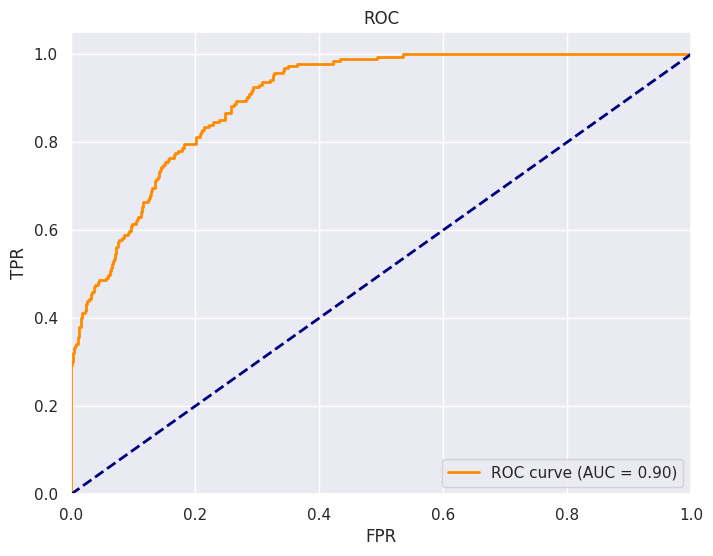

In [19]:
fpr, tpr, thresholds = m.roc_curve(y_test, [n[1] for n in model.predict_proba(X_test)])
roc_auc = m.auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [20]:
model.get_probability_threshold()

0.5

In [21]:
model.set_probability_threshold(0.4)

In [22]:
y_pred = model.predict(X_test)
print(m.classification_report(y_test, y_pred, target_names = ['Not promoted', 'Promoted']))

              precision    recall  f1-score   support

Not promoted       0.98      0.83      0.90      2006
    Promoted       0.30      0.78      0.43       187

    accuracy                           0.82      2193
   macro avg       0.64      0.80      0.66      2193
weighted avg       0.92      0.82      0.86      2193



In [23]:
shap.initjs()

In [24]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Pool(X_train, y_train, cat_features=cat_features))

In [25]:
shap.force_plot(explainer.expected_value, shap_values[0:50,:], X_train.iloc[0:50,:])

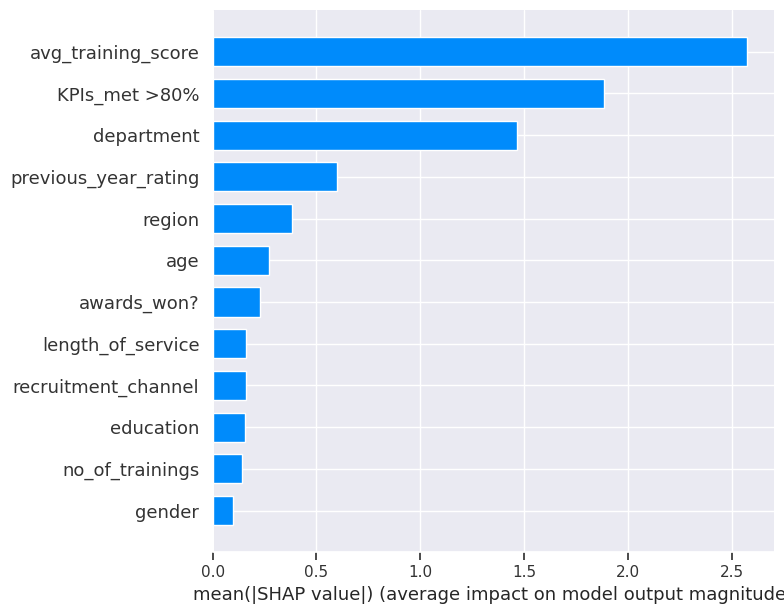

In [26]:
shap.summary_plot(shap_values, X_train, plot_type='bar')